\newpage

In [3]:
import pdfplumber
import pandas as pd
from nltk.tokenize import word_tokenize  # natural language processing 
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
from shiny import App, render, ui

pd.options.mode.chained_assignment = None  # default='warn'

## Question 1
We consider the paper, Data Science at the Singularity by David Donoho https://assets.pubpub.org/9bk0194n/Donoho%20(2024)_Just%20Accepted-11706563057147.pdf. 

In [4]:
# 1.2 - Reading PDF document and separating lines by \n
def extract_text_from_pdf(pdf_path):
    text = ''
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() + '\n'
    return text

pdf_text = extract_text_from_pdf("just_accepted_donoho.pdf")

# 1.3 Splitting lines by \n
pdf_text_split = pdf_text.split('\n')

# 1.4 Finding index where 'abstract' first appears and removing from list
idx_abstract = next((idx for idx, string in enumerate(pdf_text_split) if 'Abstract' in string), None)
pdf_text_split = pdf_text_split[9:]

# 1.5/1.6 Tokenizing each line and converting each word to a row
word_df = pd.DataFrame({'line': pdf_text_split})
word_df['word'] = word_df['line'].apply(word_tokenize)
word_df = word_df.explode('word')

# 1.7/1.8/1.9 Cleaning Data
word_df['word'] = word_df['word'].str.lower()
word_df.dropna(inplace=True)
english_stopwords = set(stopwords.words('english'))
word_df = word_df[~word_df['word'].isin(english_stopwords)]
word_df = word_df[~word_df['word'].isin(['j', 'fr-2', 'fr-3', 'e', 
                                         'fr-1', 'j.', 'fr', 'a.', 'c',
                                         'datascienceatthesingularity'])]

word_df = word_df[word_df['word'].str.contains('[a-z]')]
word_df.head()

,line,word
0,Abstract. Something fundamental to computation...,abstract
0,Abstract. Something fundamental to computation...,something
0,Abstract. Something fundamental to computation...,fundamental
0,Abstract. Something fundamental to computation...,computation-based
0,Abstract. Something fundamental to computation...,repsearch


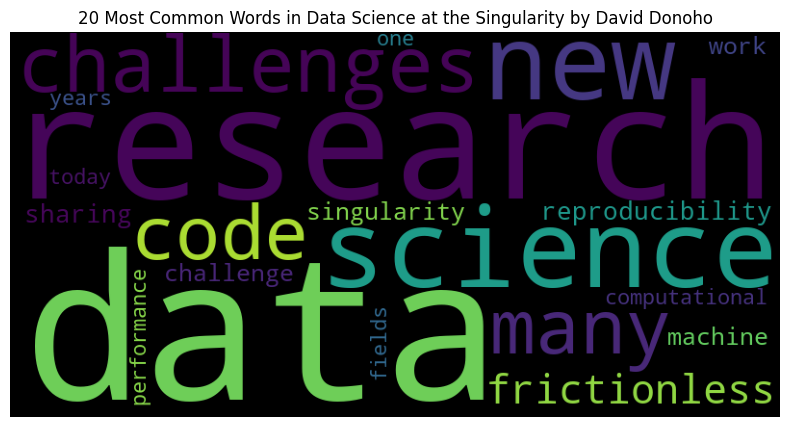

In [5]:
# 1.10 Term-Frequency Data Frame
term_freq_df = word_df['word'].value_counts().reset_index()

# 1.11 Producing word cloud for 20 most used words
term_freq_df = term_freq_df[0:20]
dc_word_freq = dict(zip(term_freq_df['word'], term_freq_df['count']))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(dc_word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('20 Most Common Words in Data Science at the Singularity by David Donoho')
plt.show()

This word cloud paints a picture of the main themes from the Donoho paper. This paper is about the future of data science, particularly with respect to frictionless reproducibility. Frictionless reproducibility refers to being able to reproduce scientific experiments easily. Donoho cites the availability of data (FR-1), code sharing (FR-2), and having transparent, easy to access tools and platforms that aid in collaboration and reproducibility (FR-3). 

These themes are reflected in the word cloud above. Some of the most common words include 'research', 'data', and 'science', which indicates that the paper discusses the use of data in scientific research. Some other common words include 'frictionless' and 'reproducibility', which is a major theme of the paper.  

## Question 2
Using the COVID-19 John Hopkins data from https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/time_series_covid19_vaccine_global.csv

In [6]:
# 2.1 - Reading .csv of covid data
url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/time_series_covid19_vaccine_global.csv'
covid_df = pd.read_csv(url)

# 2.2 - Finding dimension of data
covid_df.shape

(142597, 6)

There are 142597 observations (rows) and 6 recorded variables (columns). 

#### 2.3, describing variables
`Doses_admin` describes the cumulative number of doses administered. Note that if a vaccine required multiple doses, each dose was counted independently.

`People_at_least_one_dose` Cumulative number of people who received at least one dose. If a person received a prescribed second dose, then it is not counted again.

In [11]:
# 2.4 Getting Canada subset

covid_can_df = covid_df[covid_df['Country_Region']=='Canada']
covid_can_df['Date'] = pd.to_datetime(covid_can_df['Date'])

display(covid_can_df.head())


,Date,UID,Province_State,Country_Region,Doses_admin,People_at_least_one_dose
4,2020-12-29,124.0,NaN,Canada,59079.0,59078.0
40,2020-12-30,124.0,NaN,Canada,72092.0,72090.0
76,2020-12-31,124.0,NaN,Canada,80641.0,80639.0
116,2021-01-01,124.0,NaN,Canada,96170.0,96168.0
156,2021-01-02,124.0,NaN,Canada,105461.0,105458.0


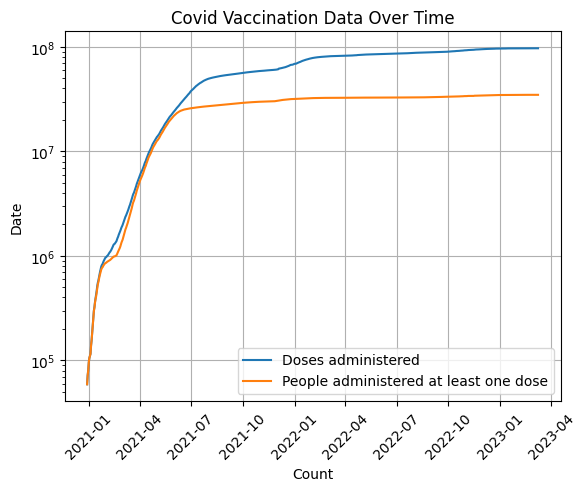

In [12]:
# 2.5 - Plotting
plt.plot(covid_can_df['Date'], covid_can_df['Doses_admin'], label='Doses administered')
plt.plot(covid_can_df['Date'], covid_can_df['People_at_least_one_dose'], label='People administered at least one dose')
plt.title('Covid Vaccination Data Over Time')
plt.xlabel('Count')
plt.ylabel('Date')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

This plot indicates that there was a sharp increase in covid vaccinations beginning January 2021, which corresponds to the time vaccines started becoming available to the general public. 

The number of people who had been administered one dose begins to level off just before July 2021.  However, the number of doses administered still increases. This is likely because at that point, everyone who had already been vaccinated continued to get boosters as recommended by government guidelines. Thus the number of people administered at least one dose would not increase, but the total number of administered doses did. 

Shiny app: https://melina-ash.shinyapps.io/asgn_2_shiny/, code in app.py file shown below.

In [8]:
import pandas as pd
from shiny import App, render, ui
import matplotlib.pyplot as plt

app_ui = ui.page_fluid(
    ui.input_date_range(
        "daterange", 
        "Date range", 
        start="2020-12-29", 
        end= '2023-03-09'
        ),  
    ui.output_plot('myplot'),
)

def server(input, output, session):
    @output
    @render.plot
    def myplot():
        
        # Read covid data
        url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/time_series_covid19_vaccine_global.csv'
        covid_df = pd.read_csv(url)

        # Select Canada subset
        covid_can_df = covid_df[covid_df['Country_Region']=='Canada']
        covid_can_df['Date'] = pd.to_datetime(covid_can_df['Date'])

        # Select user-chosen date range subset
        covid_can_df = covid_can_df[covid_can_df['Date'] > pd.Timestamp(input.daterange()[0])]
        covid_can_df = covid_can_df[covid_can_df['Date'] < pd.Timestamp(input.daterange()[1])]
        
        # Plot timeseries data
        plt.plot(covid_can_df['Date'], covid_can_df['Doses_admin'], label='Doses administered')
        plt.plot(covid_can_df['Date'], covid_can_df['People_at_least_one_dose'], label='People administered at least one dose')
        plt.title('Covid Vaccination Data Over Time')
        plt.yscale('log')
        plt.xticks(rotation=45)
        plt.grid()
        plt.legend() 

app = App(app_ui, server)